In [16]:
import matplotlib.pyplot as plt
import numpy as np
import random
from scipy import signal
import pandas as pd

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils import data

torch.cuda.set_device(2)
torch.manual_seed(0)

ROOT_PATH = "../"

# Get Data and generate spectrograms

In [17]:
song_df = pd.read_hdf(ROOT_PATH+'song_df.h5', 'song_df')

In [3]:
plt.ioff()
for i in range(len(song_df.index)):
    a = song_df.iloc[i].Data
    fig, ax = plt.subplots(1, 1, figsize=(0.375*2,0.375*2), frameon=False, facecolor='black')
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)
    ax.set_facecolor("black")
    #fig.add_axes(ax)
    frequencies, times, spectrogram = signal.spectrogram(a, 16000)
    plt.pcolormesh(np.log(spectrogram))
    plt.axis('off')
    #plt.show()
    filename = song_df.iloc[i].Name + ".png"
    #fig.set_tight_layout(True)
    extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    #plt.savefig('/tmp/test.png', bbox_inches=extent)
    fig.savefig(ROOT_PATH+"spectrograms/"+filename, bbox_inches=extent)
    plt.close(fig)

# Log of Spectrogram caused an error because spectrogram values had 0 in sing034_3 due to the pause in between.

/disk/scratch/s1769454/anaconda3/envs/dissertation/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.


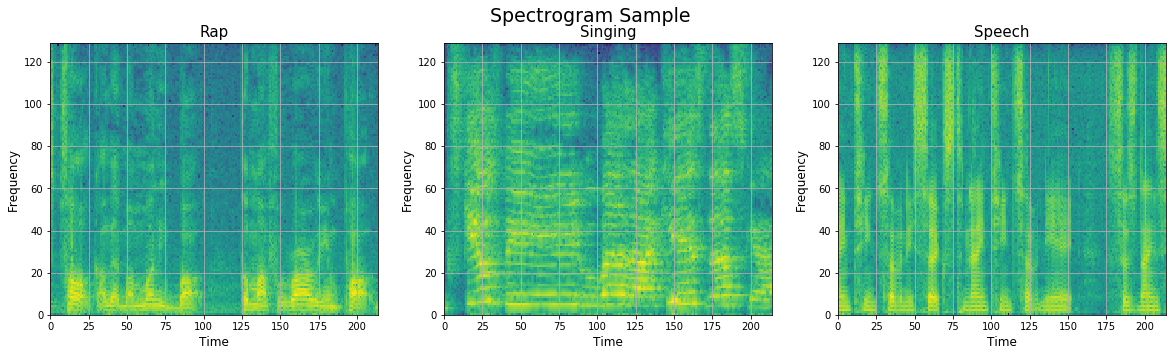

In [ ]:
fig1 = plt.figure(figsize=(20, 5))
title_list = ['Rap', 'Singing', 'Speech']
fig1.suptitle('Spectrogram Sample', fontsize=19)
s_list = [300, 300+480, 300+960]
for i, title in enumerate(title_list):
    a = song_df.iloc[s_list[i]].Data
    plt.subplot(131+i)
    plt.title(title, fontsize=15)
    frequencies, times, spectrogram = signal.spectrogram(a, 16000)
    plt.pcolormesh(np.log(spectrogram))
    plt.xlabel('Time', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.grid()
plt.show()
fig1.savefig(ROOT_PATH+"images/spectrogram_sample.pdf", bbox_inches='tight')

In [4]:
song_df.loc[song_df['Name'] == 'sing034_3']

,Name,Data,Freq,Type,MFCC,Spectrogram
373,sing034_3,"[-19464192, -16252928, -5177344, 14483456, 465...",16000,0,"[[38.812406955625654, -6.280405806858493, -13....","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,..."


# Updating the data repository

In [3]:
import cv2
import copy

In [4]:
spectro_list = []

for i in range(len(song_df.index)):
    filename = ROOT_PATH+"spectrograms/"+song_df.iloc[i].Name+".png"
    temp_pic = cv2.imread(filename)
    temp_pic = cv2.cvtColor(temp_pic, cv2.COLOR_RGB2GRAY)
    temp_pic = temp_pic/255
    r, c = temp_pic.shape
    spectro_list.append(copy.deepcopy(temp_pic[:min(r, c), :min(r, c)]))

In [5]:
song_df['Spectrogram'] = pd.Series(spectro_list, index=song_df.index)

In [6]:
song_df.to_hdf(ROOT_PATH+'song_df.h5', key='song_df')

/disk/scratch/s1769454/anaconda3/envs/dissertation/lib/python3.6/site-packages/pandas-0.23.1-py3.6-linux-x86_64.egg/pandas/core/generic.py:1993: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->['Name', 'Data', 'MFCC', 'Spectrogram']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


In [7]:
temp_pic.shape

(47, 48)

# Generating X and y for training and testing

In [8]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

In [9]:
song_df = pd.read_hdf(ROOT_PATH+'song_df.h5', 'song_df')
X = song_df.Spectrogram.values
y = song_df.Type.values

onehot_encoder = OneHotEncoder(sparse=False)
y = onehot_encoder.fit_transform(y.reshape(len(y), 1))
print(y)

[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


In [10]:
X_new = np.zeros((1440, min(r, c), min(r, c)))
for i,d in enumerate(X):
    X_new[i,:,:] = d[:, :]
print(X_new.shape)
X = X_new

(1440, 47, 47)


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [12]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42)

In [13]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(1101, 47, 47) (1101, 3)
(195, 47, 47) (195, 3)
(144, 47, 47) (144, 3)


In [14]:
# Saving the generated datasets

# Training set
np.save(ROOT_PATH+"numpy_ds/x_train_conv", X_train)
np.save(ROOT_PATH+"numpy_ds/y_train_conv", y_train)

# Validation set
np.save(ROOT_PATH+"numpy_ds/x_val_conv", X_val)
np.save(ROOT_PATH+"numpy_ds/y_val_conv", y_val)

# Test set
np.save(ROOT_PATH+"numpy_ds/x_test_conv", X_test)
np.save(ROOT_PATH+"numpy_ds/y_test_conv", y_test)

## Loading New dataset

In [15]:
X_train = np.load(ROOT_PATH+"numpy_ds/x_train_conv.npy")
X_val = np.load(ROOT_PATH+"numpy_ds/x_val_conv.npy")
X_test = np.load(ROOT_PATH+"numpy_ds/x_test_conv.npy")

y_train = np.load(ROOT_PATH+"numpy_ds/y_train_conv.npy")
y_val = np.load(ROOT_PATH+"numpy_ds/y_val_conv.npy")
y_test = np.load(ROOT_PATH+"numpy_ds/y_test_conv.npy")

# Model the Convnet

In [18]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils import data

torch.cuda.set_device(2)
torch.manual_seed(0)

In [19]:
class SpectroCNN(nn.Module):
    def __init__(self):
        super(SpectroCNN, self).__init__()
        self.conv_layer1 = nn.Conv2d(1, 16, kernel_size=5, stride=1)
        self.conv_layer2 = nn.Conv2d(16, 32, kernel_size=5, stride=1)
        self.conv_layer3 = nn.Conv2d(32, 64, kernel_size=3, stride=1)
        self.conv_layer4 = nn.Conv2d(64, 128, kernel_size=3, stride=1)
        self.conv_layer5 = nn.Conv2d(128, 256, kernel_size=3, stride=1)
    
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        
        self.drop2 = nn.Dropout2d(p=0.2)
        self.drop1 = nn.Dropout(p=0.5)
        
        self.activation_layer = nn.ReLU()
        
        self.linear_1 = nn.Linear(1024, 256)
        self.linear_2 = nn.Linear(256, 64)
        self.linear_3 = nn.Linear(64, 16)
        self.linear_4 = nn.Linear(16, 8)
        self.linear_5 = nn.Linear(8, 3)
        
        
    def forward(self, x, dim):

        out = self.conv_layer1(x)
        out = self.activation_layer(out)
        out = self.conv_layer2(out)
        out = self.activation_layer(out)
        out = self.maxpool(out)
        out = self.drop2(out)
        
        out = self.conv_layer3(out)
        out = self.activation_layer(out)
        out = self.conv_layer4(out)
        out = self.activation_layer(out)
        out = self.maxpool(out)
        out = self.drop2(out)
        
        out = self.conv_layer5(out)
        out = self.activation_layer(out)
        out = self.maxpool(out)
        
        out = out.view(dim, -1)
        out = self.linear_1(out)
        out = self.activation_layer(out)
        out = self.drop1(out)
        out = self.linear_2(out)
        out = self.activation_layer(out)
        out = self.linear_3(out)
        out = self.activation_layer(out)
        out = self.linear_4(out)
        out = self.activation_layer(out)
        out = self.linear_5(out)
        
        return out

In [20]:
random.seed(0)

def train_cnn(model, x_tr, y_tr, x_v, y_v, rows, cols, criterion, optimizer, epoch_range,  batch_size):
    losses = []
    val_losses = []
    for num_epoch in range(epoch_range):
        selected = random.sample(range(0, x_tr.shape[0]), batch_size)
        x = np.zeros((batch_size, rows, cols))
        y = np.zeros((batch_size, 3))
        for i in range(len(selected)):
            x[i, :, :] = x_tr[selected[i]]
            y[i, :] = y_tr[selected[i]]
        dim = batch_size
        x = torch.from_numpy(x).float().cuda()
        x = x.view(batch_size, -1, rows, cols)
        y = torch.from_numpy(y).long().cuda()
        #---------FORWARD------------#
        out = model.forward(x, dim)
        out = torch.tensor(out).float().cuda()
        loss = criterion(out, torch.max(y, 1)[1])
        #---------BACKWARD------------#
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        v = random.sample(range(0, x_v.shape[0]), 8)
        xv = np.zeros((8, rows, cols))
        yv = np.zeros((8, 3))
        for i in range(len(v)):
            xv[i, :, :] = x_v[v[i]]
            yv[i, :] = y_v[v[i]]
        
        xv = torch.from_numpy(xv).float().cuda()
        xv = xv.view(8, -1, rows, cols)
        yv = torch.from_numpy(yv).long().cuda()      
        
        val_out = model.forward(xv, 8)
        val_out = torch.tensor(val_out).float().cuda()
        v_loss = criterion(val_out, torch.max(yv, 1)[1])
        
        val_losses.append(v_loss.data[0])            
        losses.append(loss.data[0])
        if num_epoch%100 == 0:
            print('epoch [{}/{}], loss:{:.5f}, val:{:.5f}'.format(num_epoch + 1, epoch_range, 
                                                              loss.data[0], v_loss.data[0]))
    return losses, val_losses

In [21]:
def init_weights(layer):
    if type(layer) == nn.Linear or type(layer) == nn.Conv2d:
        nn.init.xavier_normal_(layer.weight)

In [22]:
epoch_range = 5000
batch_size = 48
learning_rate = 0.0001

cnn_1 = SpectroCNN().cuda()
cnn_1.apply(init_weights)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    cnn_1.parameters(), lr=learning_rate)

losses_1, vloss = train_cnn(cnn_1, X_train, y_train, X_val, y_val, 47, 47,
                                 criterion, optimizer, epoch_range, batch_size)

/disk/scratch/s1769454/anaconda3/envs/dissertation/lib/python3.6/site-packages/ipykernel_launcher.py:41: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/disk/scratch/s1769454/anaconda3/envs/dissertation/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/disk/scratch/s1769454/anaconda3/envs/dissertation/lib/python3.6/site-packages/ipykernel_launcher.py:45: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


epoch [1/5000], loss:1.10693, val:1.06328
epoch [101/5000], loss:1.11165, val:1.13992
epoch [201/5000], loss:1.10118, val:1.09906
epoch [301/5000], loss:1.11157, val:1.13468
epoch [401/5000], loss:1.09638, val:1.11054
epoch [501/5000], loss:1.09209, val:1.08669
epoch [601/5000], loss:1.09109, val:1.04996
epoch [701/5000], loss:1.04609, val:1.03183
epoch [801/5000], loss:0.96302, val:1.20347
epoch [901/5000], loss:0.97220, val:0.71318
epoch [1001/5000], loss:0.83288, val:0.74364
epoch [1101/5000], loss:0.85150, val:0.52004
epoch [1201/5000], loss:0.81088, val:0.40289
epoch [1301/5000], loss:0.56901, val:0.70664
epoch [1401/5000], loss:0.80603, val:0.74053
epoch [1501/5000], loss:0.70651, val:0.46186
epoch [1601/5000], loss:0.47783, val:0.77667
epoch [1701/5000], loss:0.54890, val:0.34335
epoch [1801/5000], loss:0.48883, val:0.17273
epoch [1901/5000], loss:0.41981, val:0.46188
epoch [2001/5000], loss:0.61715, val:0.49576
epoch [2101/5000], loss:0.36720, val:0.07580
epoch [2201/5000], los

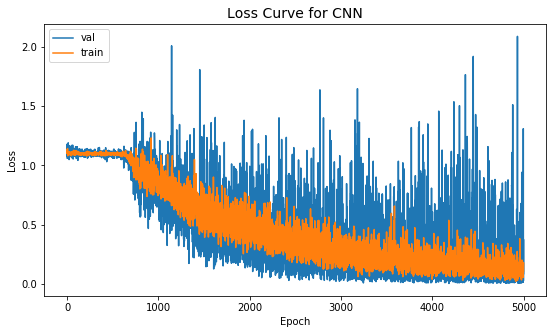

In [25]:
fig = plt.figure(figsize=(9, 5))
plt.title("Loss Curve for CNN", fontsize=14)
plt.plot(vloss, label="val")
plt.plot(losses_1, label="train")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
fig.savefig(ROOT_PATH+"images/cnn_performance.pdf", bbox_inches='tight')

# Testing on the Test Set

In [24]:
total = y_test.shape[0]
correct = 0

for i in range(X_test.shape[0]):
    data = X_test[i, :, :]
    data = torch.from_numpy(data).float().cuda()
    data = data.view(1, -1, 47, 47)
    true_out = y_test[i, :]
    mdl_out = cnn_1.forward(data, 1)
    out = (mdl_out.data).cpu().numpy()
    if np.argmax(out) == np.argmax(true_out):
        correct += 1
print("Accuracy = ", correct*100/total)

Accuracy =  88.19444444444444


In [26]:
torch.save(cnn_1, ROOT_PATH+'models/cnn_speechmode.pt')

/disk/scratch/s1769454/anaconda3/envs/dissertation/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type SpectroCNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
